In [5]:
import torch
import matplotlib.pyplot as plt
import sys
from neuralop.models import TFNO
from neuralop import Trainer
from neuralop.training import OutputEncoderCallback
from neuralop.datasets import load_darcy_flow_small
from neuralop.utils import count_params
from neuralop import LpLoss, H1Loss

device = 'cpu'

In [6]:
train_loader, test_loaders, output_encoder = load_darcy_flow_small(
        n_train=1000, batch_size=64,
        test_resolutions=[16, 32], n_tests=[100, 50],
        test_batch_sizes=[32, 32],
)

UnitGaussianNormalizer init on 1000, reducing over [0, 1, 2, 3], samples of shape [1, 16, 16].
   Mean and std of shape torch.Size([1, 1, 1]), eps=1e-05
Loading test db at resolution 32 with 50 samples and batch-size=32


In [7]:
for batch in train_loader:
    print(batch['x'].shape, batch['y'].shape)
    break

torch.Size([64, 3, 16, 16]) torch.Size([64, 1, 16, 16])


In [8]:
for batch in test_loaders[32]:
    print(batch['x'].shape, batch['y'].shape)
    break

torch.Size([32, 3, 32, 32]) torch.Size([32, 1, 32, 32])


In [9]:
model = TFNO(n_modes=(16, 16), hidden_channels=32, projection_channels=64, factorization='tucker', rank=0.42)
model = model.to(device)

n_params = count_params(model)
print(f'\nOur model has {n_params} parameters.')
sys.stdout.flush()


Our model has 402785 parameters.


In [10]:
optimizer = torch.optim.Adam(model.parameters(),
                                lr=8e-3,
                                weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)

In [11]:
l2loss = LpLoss(d=2, p=2)
h1loss = H1Loss(d=2)

train_loss = h1loss
eval_losses={'h1': h1loss, 'l2': l2loss}

In [12]:
print('\n### MODEL ###\n', model)
print('\n### OPTIMIZER ###\n', optimizer)
print('\n### SCHEDULER ###\n', scheduler)
print('\n### LOSSES ###')
print(f'\n * Train: {train_loss}')
print(f'\n * Test: {eval_losses}')
sys.stdout.flush()


### MODEL ###
 TFNO(
  (fno_blocks): FNOBlocks(
    (convs): SpectralConv(
      (weight): ModuleList(
        (0-7): 8 x ComplexTuckerTensor(shape=(32, 32, 8, 8), rank=(25, 25, 6, 6))
      )
    )
    (fno_skips): ModuleList(
      (0-3): 4 x Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
  )
  (lifting): MLP(
    (fcs): ModuleList(
      (0): Conv2d(3, 256, kernel_size=(1, 1), stride=(1, 1))
      (1): Conv2d(256, 32, kernel_size=(1, 1), stride=(1, 1))
    )
  )
  (projection): MLP(
    (fcs): ModuleList(
      (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
      (1): Conv2d(64, 1, kernel_size=(1, 1), stride=(1, 1))
    )
  )
)

### OPTIMIZER ###
 Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 0.008
    lr: 0.008
    maximize: False
    weight_decay: 0.0001
)

### SCHEDULER ###

### LOSSES ###

 * Train: <neuralop.trainin

In [13]:
# trainer = Trainer(model=model, n_epochs=20,
#                   device=device,
#                   callbacks=[OutputEncoderCallback(output_encoder)],
#                   wandb_log=False,
#                   log_test_interval=3,
#                   use_distributed=False,
#                   verbose=True)

In [14]:
# trainer.train(train_loader=train_loader,
#               test_loaders=test_loaders,
#               optimizer=optimizer,
#               scheduler=scheduler,
#               regularizer=False,
#               training_loss=train_loss,
#               eval_losses=eval_losses)

/var/folders/ql/9xssmql12wbdjz6d8yqxxfpc0000gq/T/ipykernel_5748/1629527072.py:38: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


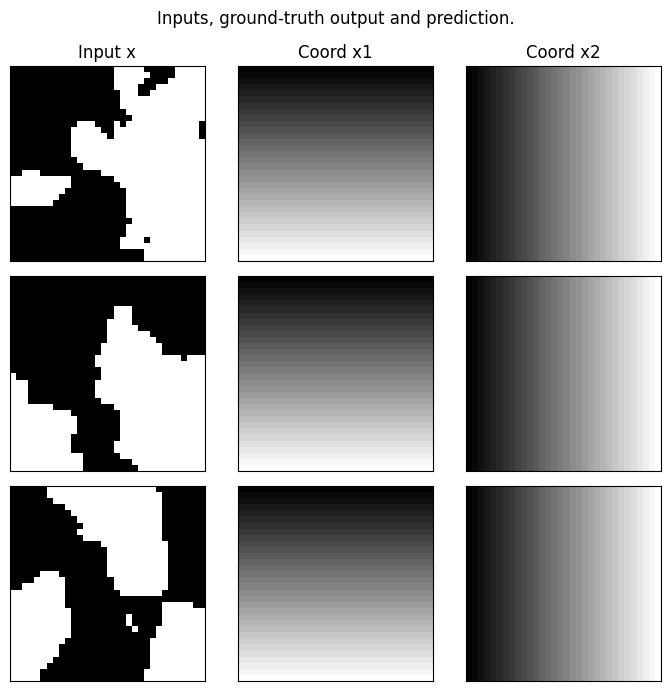

In [15]:
test_samples = test_loaders[32].dataset

fig = plt.figure(figsize=(7, 7))
for index in range(3):
    data = test_samples[index]
    # Input x
    x = data['x']
    # Ground-truth
    y = data['y']
    # Model prediction
    # out = model(x.unsqueeze(0))
    ax = fig.add_subplot(3, 3, index*3 + 1)
    ax.imshow(x[0], cmap='gray')
    if index == 0:
        ax.set_title('Input x')
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(3, 3, index*3 + 2)
    ax.imshow(x[1], cmap='gray')
    # ax.imshow(y.squeeze())
    if index == 0:
        ax.set_title('Coord x1')
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(3, 3, index*3 + 3)
    # ax.imshow(out.squeeze().detach().numpy())

    ax.imshow(x[2], cmap='gray')
    if index == 0:
        ax.set_title('Coord x2')
    plt.xticks([], [])
    plt.yticks([], [])

fig.suptitle('Inputs, ground-truth output and prediction.', y=0.98)
plt.tight_layout()
fig.show()

In [16]:
from neuralop.datasets import load_spherical_swe

train_loader, test_loaders = load_spherical_swe(n_train=200, batch_size=4, train_resolution=(32, 64),
                                                test_resolutions=[(32, 64), (64, 128)], n_tests=[50, 50], test_batch_sizes=[10, 10],)

Loading train dataloader at resolution (32, 64) with 200 samples and batch-size=4
Loading test dataloader at resolution (32, 64) with 50 samples and batch-size=10
Loading test dataloader at resolution (64, 128) with 50 samples and batch-size=10


In [19]:
for dat in train_loader:
    print(dat['x'].shape)
    break

torch.Size([4, 3, 32, 64])
